# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

In [1]:
# ---------------------------- Udacity Workspace ---------------------------- #
# !pip -q install ./python
# from unityagents import UnityEnvironment
# import numpy as np

# env = UnityEnvironment(file_name='/data/Tennis_Linux_NoVis/Tennis')

# ------------------------------ Local machine ------------------------------ #
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [4]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.09000000171363354
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Agent

In [5]:
from ddpg_agent import Agent
from maddpg_wrapper import maddpg_wrapper

Agents = maddpg_wrapper(Agent)

agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

#### MADDPG

In [6]:
from collections import deque
import torch
import torch.nn.functional as F
import torch.optim as optim

def maddpg(n_episodes=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.9995):
# def maddpg(n_episodes=10000, eps_start=1.0, eps_end=0.05, eps_decay=3e-5):
    scores_deque = deque(maxlen=100)
    scores_lst = []
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        global agent
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(agent.num_agents)                    # initialize the score (for each agent)
        agent.reset()
        while True:
            actions = agent.act(states, eps)                   # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
#             eps = max(eps_end, (eps-eps_decay))                # decrease epsilon
            
            agent.step(states, actions, rewards, next_states, dones)
    
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        score = np.mean(scores)
        scores_deque.append(score)
        scores_lst.append(score)
        print('\rEpisode {}\tScore: {:.2f}\t*Average Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, score, np.mean(scores_deque), eps))
        eps = max(eps_end, eps*eps_decay)                     # decrease epsilon
        for i, a in enumerate(agent.agents):
            torch.save(a.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
            torch.save(a.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(i))
        if np.mean(scores_deque) >= 0.5 and len(scores_deque) >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
    return scores_lst

In [7]:
TRAIN = False

In [8]:
import json

if TRAIN == True:
#     # Udacity Workspace
#     from workspace_utils import active_session

#     with active_session():
#         scores = maddpg()
#         with open("scores_file.json", "w") as write_file:
#             json.dump(scores, write_file)
            
    # Local Machine
    scores = maddpg()
    with open("scores_file.json", "w") as write_file:
        json.dump(scores, write_file)

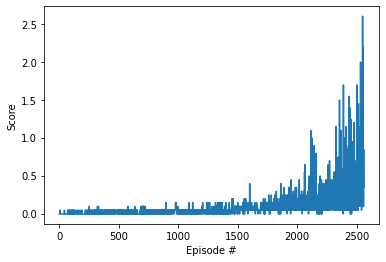

In [9]:
import matplotlib.pyplot as plt

with open("scores_file.json", "r") as read_file:
    scores = json.load(read_file)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.savefig('scores_eps.png')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent

In [10]:
map_location = "cuda:0" if torch.cuda.is_available() else "cpu"

for i, agent in enumerate(agent.agents):
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_{}.pth'.format(i), map_location=map_location))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic_{}.pth'.format(i), map_location=map_location))

In [11]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 2.600000038743019


When finished, you can close the environment.

In [12]:
env.close()

### 6. Outlook
* When we have computing power, the grid search, Bayesian opitimization, or other systematic techniques can be applied to search the optimal hyperparameters.
* We can implement Prioritized Experience Replay. It helps to improve the performance and significantly reduces the training time.